# IMDb dataset

In [1]:
%matplotlib inline

import sys
import os
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import torch
import pandas
import PIL.Image

sys.path.append("../../")
from experiments.datasets import IMDBLoader


## Options

In [2]:
transform = False


## Preprocessing: Transform images and age info to numpy arrays (only need to do this once)

In [3]:
test_fraction = 0.1


def process_images(filenames, ages, facescores1, facescores2, category="train", subfolders=True, basedir=f"../data/samples/imdb"):
    filenames_out = []
    ages_out = []
    i = 0
    
    for filename, age, fs1, fs2 in zip(filenames, ages, facescores1, facescores2):
        img = PIL.Image.open(f"{basedir}/raw/{filename}")
        dims = np.array(img).shape
        
        if len(dims) != 3 or dims[2] != 3 or dims[0] != dims[1] or dims[0] < 64:  # Let's skip b/w and non-square images (the latter are often corrupted)
            continue
        if age < 18 or age > 80:  # Let's limit it to this range
            continue
        if not np.isfinite(fs1):
            continue
        if np.isfinite(fs2):
            continue
            
        img = img.resize((64, 64), PIL.Image.ANTIALIAS)
            
        folder = f"{category}/{(i // 1000):03d}" if subfolders else category
        img_filename_out = f"{folder}/{category}_{i:05d}.png"
        
        os.makedirs(f"{basedir}/{folder}", exist_ok=True)
        img.save(f"{basedir}/{img_filename_out}")
        filenames_out.append(img_filename_out)
        ages_out.append(age)
        
        i += 1
    
    df_out = pandas.DataFrame({'age':ages_out, 'filename':filenames_out})
    df_out.to_csv(f"{basedir}/{category}.csv")
    
    return df_out


df = pandas.read_csv("../data/samples/imdb/raw.csv")
n = len(df)
n_test = int(round(n * test_fraction))

np.random.seed(81357)
idx_all = list(range(n))
np.random.shuffle(idx_all)
idx_train, idx_test = idx_all[n_test:], idx_all[:n_test]

if transform:
    dfs = {}
    for cat, idx in zip(["train", "test"], [idx_train, idx_test]):
        paths = np.array(df["path"])[idx]
        age = np.array(df["age"])[idx]
        fs1 = np.array(df["facescore1"])[idx]
        fs2 = np.array(df["facescore2"])[idx]

        dfs[cat] = process_images(paths, age, fs1, fs2, cat, subfolders=(cat=="train"))

        age_pdf, age_edges = np.histogram(df["age"], range=(17.5, 80.5), bins=63, density=True)
        ages = (age_edges[1:] + age_edges[:-1])/2


## Age distribution

In [4]:
age_pdf, _ = np.histogram(df["age"], range=(17.5, 80.5), bins=63, density=True)

print("age_vals = np.linspace(18, 80, 63)")
print("age_probs = np.array([" + ", ".join([str(x) for x in age_pdf]) + "])")

age_vals = np.linspace(18, 80, 63)
age_probs = np.array([0.00835267561232834, 0.011491477628632799, 0.016188291676252388, 0.018384086410445057, 0.01868247760357705, 0.022894121237936226, 0.02284856533058783, 0.0294200049655939, 0.025796032536029027, 0.03264080761512547, 0.028750333127572487, 0.03487076927982944, 0.034478988476633235, 0.03969741766339196, 0.03612583452727774, 0.033422091426150456, 0.034677156673598754, 0.03421476421401254, 0.03554499670858569, 0.030665959031572522, 0.03445848831832646, 0.034176041692766404, 0.0275544905596771, 0.026483926736989804, 0.026841540609674707, 0.024297243184266813, 0.021582111106302433, 0.023329180153113405, 0.021431776612052728, 0.0171335767537316, 0.017021964780728028, 0.015117727853565091, 0.013846718038544854, 0.013019878320171473, 0.01211103796857098, 0.011318365180708896, 0.009049680994758794, 0.009450572979424674, 0.007758171021431777, 0.00730944533405008, 0.007550891642996577, 0.007124943909289077, 0.007402834944114291, 0.0061432141059

In [5]:
np.std(df["age"]), np.mean(df["age"])

(35.52156863651862, 37.45325282219468)

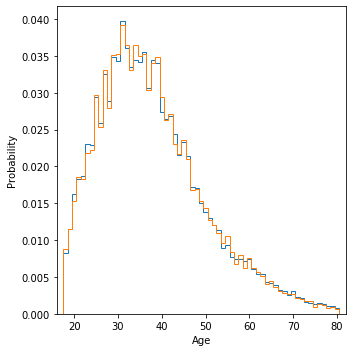

In [6]:
fig = plt.figure(figsize=(5,5))

plt.hist(np.array(df["age"])[idx_train], range=(17.5, 80.5), bins=63, histtype="step", color="C0", label="Train", density=True)
plt.hist(np.array(df["age"])[idx_test], range=(17.5, 80.5), bins=63, histtype="step", color="C1", label="Test", density=True)

plt.xlim(16, 82)
plt.ylim(0., None)
plt.xlabel("Age")
plt.ylabel("Probability")

plt.tight_layout()
plt.show()


## Test DataLoader

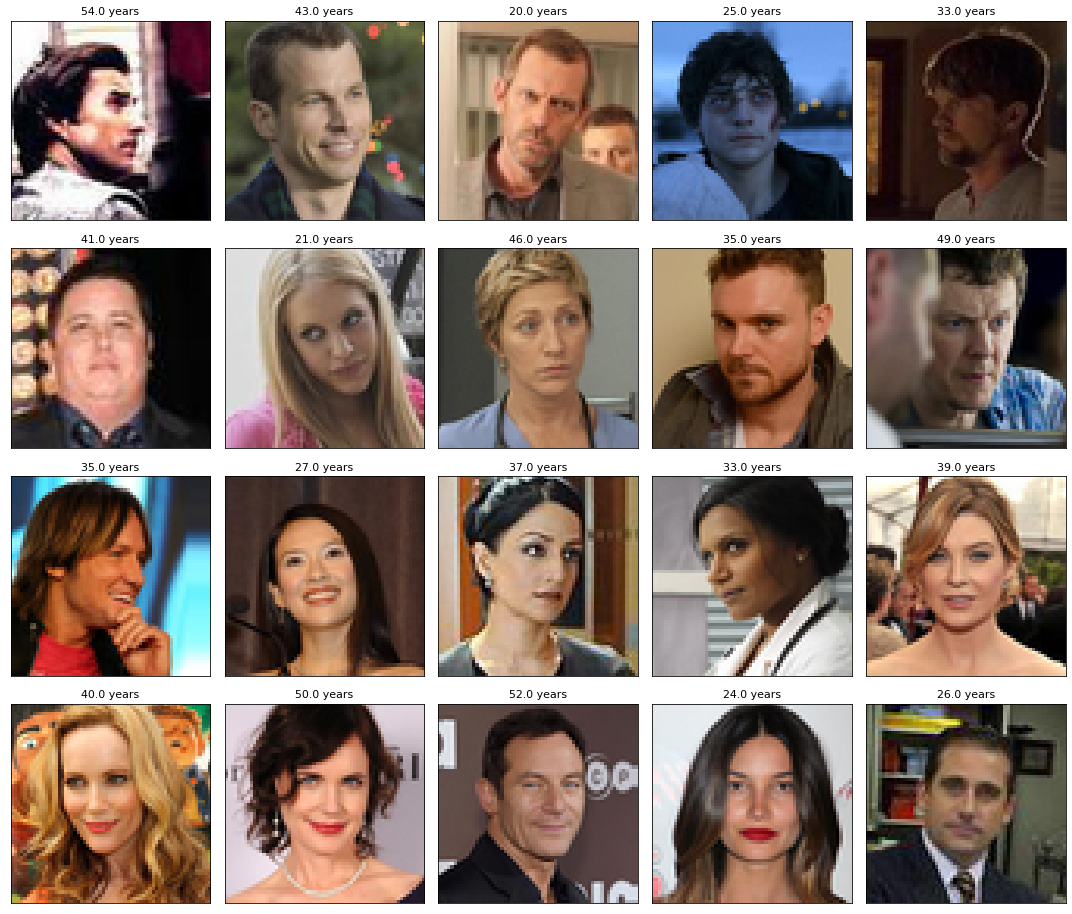

In [13]:
loader = IMDBLoader()
data = loader.load_dataset(train=True, dataset_dir="../data/samples/imdb")

fig = plt.figure(figsize=(5*3., 4*3.2))

for i in range(20):
    x, y = data[np.random.randint(len(data) - 1)]
    y = loader._preprocess_age(y, inverse=True)[0]
    x_ = np.transpose(np.array(x), [1,2,0]) / 256.
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(x_)
    plt.title(f"{y} years", fontsize=11.)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()



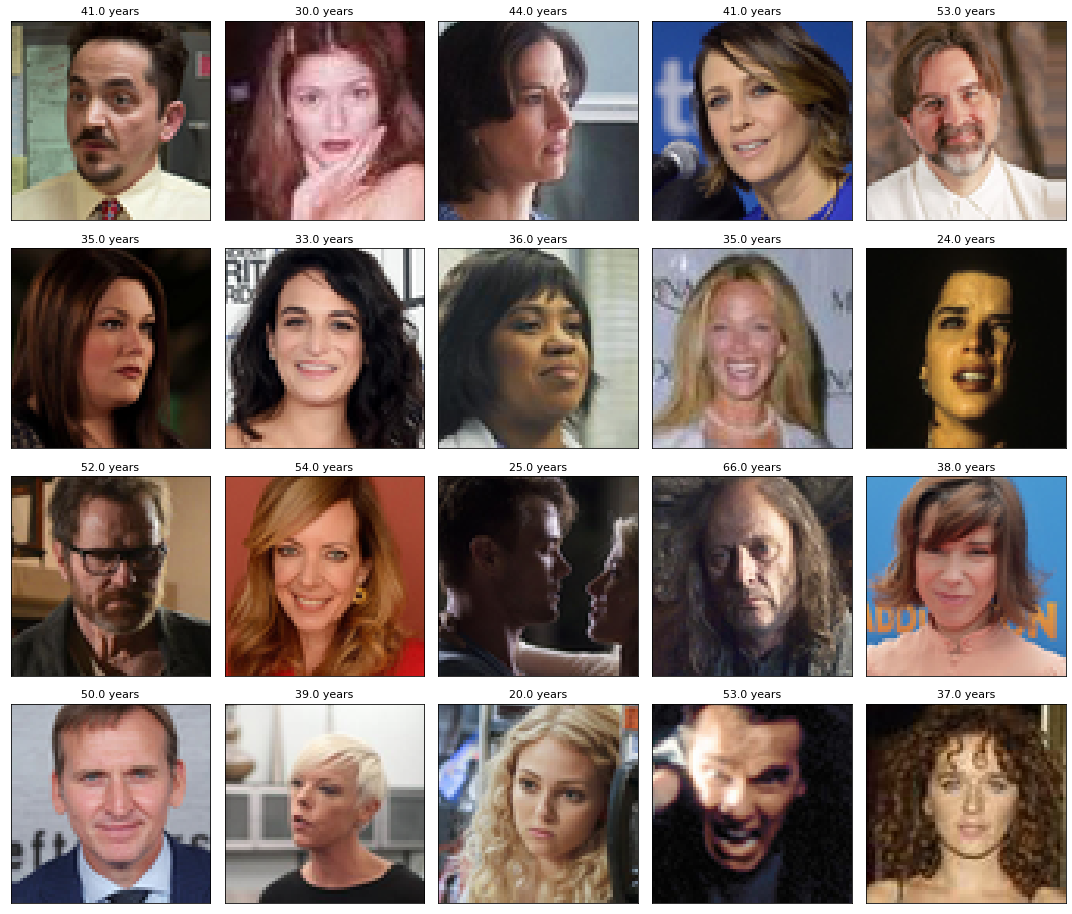

In [14]:
loader = IMDBLoader()
data = loader.load_dataset(train=False, dataset_dir="../data/samples/imdb")

fig = plt.figure(figsize=(5*3., 4*3.2))

for i in range(20):
    x, y = data[np.random.randint(len(data) - 1)]
    y = loader._preprocess_age(y, inverse=True)[0]
    x_ = np.transpose(np.array(x), [1,2,0]) / 256.
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(x_)
    plt.title(f"{y} years", fontsize=11.)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()
